In [6]:
train_dir = 'asl_alphabet_train'
# val_dir = 'asl_alphabet_val'
IMG_SIZE = 200,200

In [7]:
!ls asl_alphabet_train

A  C  del  F  H  J  L  N	O  Q  run.py  script.sh  T  V  X  Z
B  D  E    G  I  K  M  nothing	P  R  S       space	 U  W  Y


In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
from keras import regularizers
import cv2
import matplotlib.pyplot as plt
import glob
from keras.layers import *
from keras.models import *

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(   
    directory=train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    seed=40,
    batch_size=256,
    validation_split=0.2,
    # shuffle=False,
    subset='training'
)

val_data = tf.keras.preprocessing.image_dataset_from_directory( 
    directory=train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    seed=40,
    validation_split=0.2,
    batch_size=256,
    subset='validation',
    # shuffle=False,
    interpolation="bilinear"
)

Found 11196 files belonging to 29 classes.
Using 8957 files for training.


2023-02-27 18:34:03.003226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 18:34:03.035300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 18:34:03.035418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 18:34:03.035767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Found 11196 files belonging to 29 classes.
Using 2239 files for validation.


In [10]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import RandomBrightness, RandomContrast
# from tensorflow.keras.layers import RandomHue
from tensorflow.keras.layers import GaussianNoise
# import keras_cv
data_augmentation = Sequential([
    RandomBrightness(0.2),
    # Điều chỉnh độ tương phản
    RandomContrast(0.2),
    # Thêm nhiễu Gaussian
    GaussianNoise(0.1)
], name ="data_augmentation")

In [11]:
input_shape = (200, 200, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Tạo layer đầu vào
inputs = Input(shape=input_shape, name="input_layer")

# Thêm vào mô hình tuần tự tăng cường dữ liệu dưới dạng layer
x = data_augmentation(inputs)

# Cung cấp đầu vào cho base_model (sau khi tăng cường) và không huấn luyện nó 
x = base_model(x, training=False)

# Gộp các đặc trưng đầu ra của base model
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(256)(x)
x = Dropout(rate=.4)(x)  
# x = Dense(128)(x)
# x = Dropout(rate=.4)(x) 
# Đặt dense layer làm đầu ra
outputs = Dense(29, activation="softmax", name="output_layer")(x)

# Tạo mô hình với đầu vào và đầu ra
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 200, 200, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                             

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15, verbose=1)

filepath="best_model_new3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    """
    Hàm callback trả về learning rate mới cho mỗi epoch
    """
    lr = .005
    if epoch > 4:
        lr = .003
    if epoch > 8:
        lr = .001
    return lr

# Tạo instance của LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks_list = [early_stopping, checkpoint, lr_scheduler]

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model_hist = model.fit(train_data,validation_data = val_data, epochs = 60, callbacks=callbacks_list)

Epoch 1/60


2023-02-27 09:37:29.559065: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


40/40 [==============================] - ETA: 0s - loss: 1.3368 - accuracy: 0.7471
Epoch 1: val_accuracy improved from -inf to 0.83557, saving model to best_model_new3.h5
40/40 [==============================] - 70s 2s/step - loss: 1.3368 - accuracy: 0.7471 - val_loss: 0.4859 - val_accuracy: 0.8356 - lr: 0.0050
Epoch 2/60
40/40 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.9150
Epoch 2: val_accuracy improved from 0.83557 to 0.92136, saving model to best_model_new3.h5
40/40 [==============================] - 65s 2s/step - loss: 0.3688 - accuracy: 0.9150 - val_loss: 0.2484 - val_accuracy: 0.9214 - lr: 0.0050
Epoch 3/60
40/40 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9416
Epoch 3: val_accuracy improved from 0.92136 to 0.93208, saving model to best_model_new3.h5
40/40 [==============================] - 65s 2s/step - loss: 0.2298 - accuracy: 0.9416 - val_loss: 0.2086 - val_accuracy: 0.9321 - lr: 0.0050
Epoch 4/60
40/40 [===============

In [10]:
model.save('model.h5')

In [ ]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.legend(['train', 'val'], loc='lower right')
plt.title('accuracy plot - train vs val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [16]:
model = keras.models.load_model('best_model_new3.h5')

In [17]:
evaluate_metrics = model.evaluate(val_data)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

9/9 [==============================] - 3s 256ms/step - loss: 0.0285 - accuracy: 0.9924

Evaluation Accuracy =  99.24% 
Evaluation loss =  0.028527


In [18]:
labels = []
predicts = []
for image, label in val_data.unbatch():
    predict = np.argmax(np.squeeze(model.predict(image.numpy().reshape(1,200,200,3))))
    predicts.append(predict)
    labels.append(np.argmax(label))

predicts = np.array(predicts)
labels = np.array(labels)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

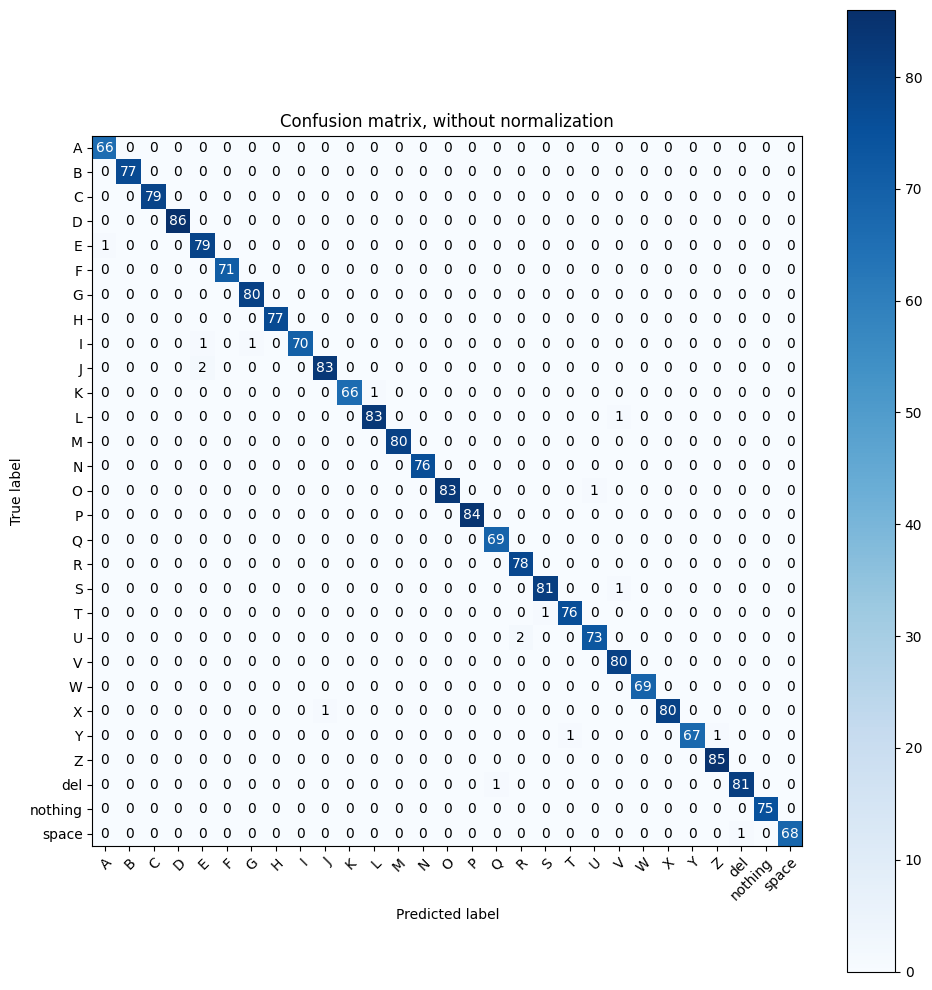

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(labels, predicts)
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(labels, predicts, classes = train_data.class_names)
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(labels, predicts))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        66
           1       1.00      1.00      1.00        77
           2       1.00      1.00      1.00        79
           3       1.00      1.00      1.00        86
           4       0.96      0.99      0.98        80
           5       1.00      1.00      1.00        71
           6       0.99      1.00      0.99        80
           7       1.00      1.00      1.00        77
           8       1.00      0.97      0.99        72
           9       0.99      0.98      0.98        85
          10       1.00      0.99      0.99        67
          11       0.99      0.99      0.99        84
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        76
          14       1.00      0.99      0.99        84
          15       1.00      1.00      1.00        84
          16       0.99      1.00      0.99        69
          17       0.97    